<a href="https://colab.research.google.com/github/Ananassio/Data-Science_lab/blob/main/Project/Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importieren der Daten

In [1]:
#get data from server
!wget --no-check-certificate https://www.keuper-labs.org/project_ss22.zip

--2022-06-03 12:22:18--  https://www.keuper-labs.org/project_ss22.zip
Resolving www.keuper-labs.org (www.keuper-labs.org)... 91.250.118.129
Connecting to www.keuper-labs.org (www.keuper-labs.org)|91.250.118.129|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 70859177 (68M) [application/zip]
Saving to: ‘project_ss22.zip’

project_ss22.zip    100%[===================>]  67.58M  11.4MB/s    in 6.8s    

2022-06-03 12:22:25 (10.0 MB/s) - ‘project_ss22.zip’ saved [70859177/70859177]



In [2]:
#unpack
!unzip project_ss22.zip

Archive:  project_ss22.zip
   creating: dressipi_recsys2022/
  inflating: dressipi_recsys2022/candidate_items.csv  
  inflating: dressipi_recsys2022/item_features.csv  
  inflating: dressipi_recsys2022/test_leaderboard_sessions.csv  
  inflating: dressipi_recsys2022/test_final_sessions.csv  
  inflating: dressipi_recsys2022/README.txt  
  inflating: dressipi_recsys2022/train_purchases.csv  
  inflating: dressipi_recsys2022/train_sessions.csv  
  inflating: dressipi_recsys2022/README_win.txt  


In [3]:
# import some libarys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

In [4]:
# asign the Data to variables
items = pd.read_csv('dressipi_recsys2022/candidate_items.csv')
features = pd.read_csv('dressipi_recsys2022/item_features.csv')
train_purchases = pd.read_csv('dressipi_recsys2022/train_purchases.csv')
train_sessions = pd.read_csv('dressipi_recsys2022/train_sessions.csv')
test_leaderboard_sessions = pd.read_csv('dressipi_recsys2022/test_leaderboard_sessions.csv')

## Blick auf die Daten
Hier werden zunächst die Datensätze einmal ausgegeben, um einen Überblick 
zubekommen wie diese aufgebaut sind.



---




In dem items Datensatz sind die item ids, welche in bei den testsessions gekauft wurden 

In [5]:
items

,item_id
0,4
1,8
2,9
3,19
4,20
...,...
4985,28128
4986,28131
4987,28132
4988,28133


In [6]:
#how many items do we have?
items.describe()

,item_id
count,4990.000000
mean,14007.035271
std,8218.231425
min,4.000000
25%,6833.500000
50%,14108.500000
75%,21200.000000
max,28137.000000




---


In dem features Dataset sind die entsprechenden item features der jeweiligen items aufgelistet. Dabei werden die feature Kategorien wie Farbe, Ausschnitt, etc mit einer value id z.B. grün beschrieben. Die einzelnen items haben mehrere Kategorien, welche die items beschreiben, siehe hier z.B. item 2 hat 13 feature Kategorien.

In [7]:
features.head(50)

,item_id,feature_category_id,feature_value_id
0,2,56,365
1,2,62,801
2,2,68,351
3,2,33,802
4,2,72,75
5,2,29,123
6,2,16,38
7,2,50,76
8,2,61,462
9,2,53,6


In [8]:
features.describe()

,item_id,feature_category_id,feature_value_id
count,471751.000000,471751.000000,471751.000000
mean,14058.539477,42.424597,486.345578
std,8107.465455,22.186285,258.865151
min,2.000000,1.000000,1.000000
25%,7060.000000,25.000000,273.000000
50%,14045.000000,47.000000,512.000000
75%,21063.000000,61.000000,708.000000
max,28143.000000,73.000000,905.000000




---


Der Train_purchases Datensatz beinhaltet eine item id, welche am Ende der jeweiligen session letzlich gekauft wurde. Zusätzlich gibt es dabei noch einen Zeitstempel.
Die gesamten Daten wurden in einem Zeitraum von 18 Monaten aufgezeichnet, dabei wurden Daten der ersten 17 Monate für den Trainingsdatensatz verwendet und der letzte Monat wurde für den Testdatensatz verwendet.

In [9]:
train_purchases

,session_id,item_id,date
0,3,15085,2020-12-18 21:26:47.986
1,13,18626,2020-03-13 19:36:15.507
2,18,24911,2020-08-26 19:20:32.049
3,19,12534,2020-11-02 17:16:45.92
4,24,13226,2020-02-26 18:27:44.114
...,...,...,...
999995,4439986,2915,2021-05-13 11:56:37.464
999996,4439990,8786,2020-08-22 14:28:22.382
999997,4439994,21630,2020-11-27 20:10:28.961
999998,4439999,16962,2020-11-27 11:01:41.356




---


In dem Datensatz train_session sind die item ids aufgelistet, welche innerhalb einer session angesehen wurden. Auch hier gibt es jeweils einen Zeitstempel.

In [10]:
train_sessions

,session_id,item_id,date
0,3,9655,2020-12-18 21:25:00.373
1,3,9655,2020-12-18 21:19:48.093
2,13,15654,2020-03-13 19:35:27.136
3,18,18316,2020-08-26 19:18:30.833
4,18,2507,2020-08-26 19:16:31.211
...,...,...,...
4743815,4440001,20409,2020-10-30 23:37:20.658
4743816,4440001,14155,2020-10-30 23:31:56.607
4743817,4440001,14303,2020-10-30 23:36:17.934
4743818,4440001,27852,2020-10-30 23:39:55.186




---


Auf den Daten des Datensatzes test_leaderboard_session sollen die Vorhersagen für die Bestenliste des Wettbewerbs getätigt werden. 

In [11]:
test_leaderboard_sessions

,session_id,item_id,date
0,26,19185,2021-06-16 09:53:54.158
1,200,17089,2021-06-25 12:23:40.811
2,200,17089,2021-06-25 12:24:36.631
3,200,8060,2021-06-25 12:24:41.677
4,200,4758,2021-06-25 12:24:50.692
...,...,...,...
229349,4439653,25955,2021-06-11 10:22:57.47
229350,4439653,12179,2021-06-11 10:23:00.663
229351,4439757,2078,2021-06-30 11:42:15.073
229352,4439757,2078,2021-06-30 11:43:13.725


# Datenanalyse
Hier soll ein überblick geschaffen werden, wie die Daten verteilt sind

## Anzahl der Sessions pro Kauf

In [12]:
# first count the ammount of the session numbers
A = pd.DataFrame(train_sessions['session_id'].value_counts().sort_values())['session_id'].value_counts()

In [13]:
A.to_frame()

,session_id
1,307698
2,174775
3,115499
4,82306
5,60695
...,...
100,6
91,6
98,5
99,5


In [14]:
# lets use the describe function for better analysing of the numbers 
train_sessions['session_id'].value_counts().sort_values().describe()

count    1000000.000000
mean           4.743820
std            6.084665
min            1.000000
25%            1.000000
50%            3.000000
75%            6.000000
max          100.000000
Name: session_id, dtype: float64

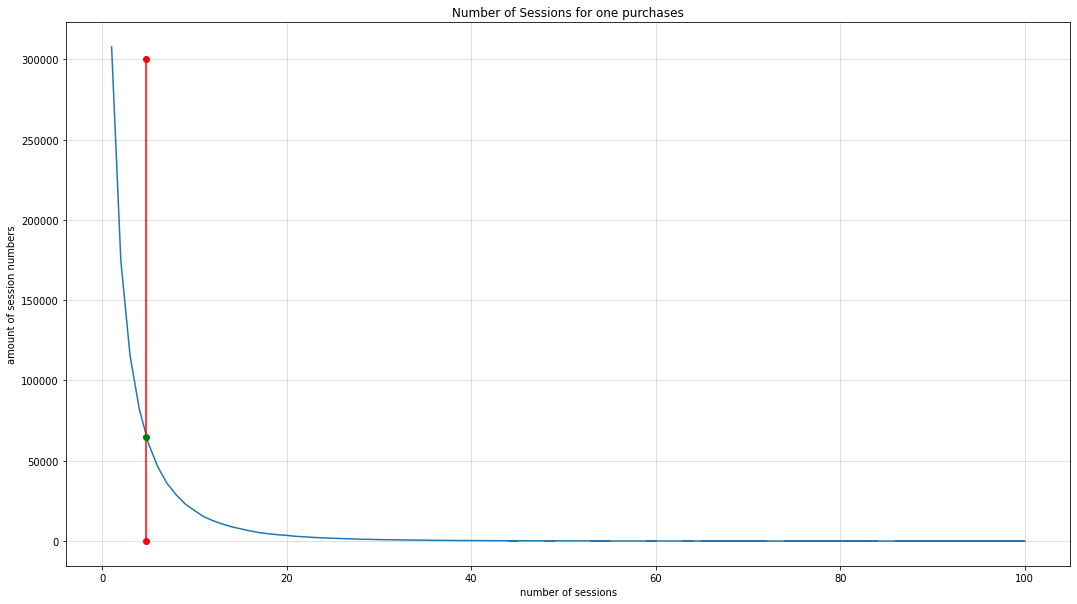

In [15]:
# print the generated curve of the session ammounts
fig, axes = plt.subplots(figsize=(18,10))

axes.plot(A)
axes.plot([4.743820,4.743820], [0,300000], '-ro', label='line & marker')
axes.plot(4.743820,65000, 'go', label='marker only')
axes.set_xlabel('number of sessions')
axes.set_ylabel('amount of session numbers')
axes.set_title('Number of Sessions for one purchases');
axes.grid(alpha=0.5)

## Verteilung der Käufe
Als nächsten Schritt wird geschaut an welchen Tagen, zu welchen Uhrzeiten und in welchem Monat die Items gekauft werden.


In [16]:
# then look at the train_purchases Dataset
t_purchase_times = pd.DataFrame();
t_purchase_times['day']=pd.to_datetime(train_sessions['date']).dt.day_name()
t_purchase_times['month']=pd.to_datetime(train_sessions['date']).dt.month_name()
t_purchase_times['year']=pd.to_datetime(train_sessions['date']).dt.year
t_purchase_times['part_of_day'] = (pd.to_datetime(train_sessions['date']).dt.hour % 24 + 4) // 4
t_purchase_times['part_of_day'].replace({1: 'Late Night', # 0-4 Uhr
                      2: 'Early Morning',                 # 4-8 Uhr
                      3: 'Morning',                       # 8-12 Uhr
                      4: 'Noon',                          # 12-16 Uhr
                      5: 'Evening',                       # 16-20 Uhr
                      6: 'Night'}, inplace=True)          # 20-0 Uhr
t_purchase_times

,day,month,year,part_of_day
0,Friday,December,2020,Night
1,Friday,December,2020,Night
2,Friday,March,2020,Evening
3,Wednesday,August,2020,Evening
4,Wednesday,August,2020,Evening
...,...,...,...,...
4743815,Friday,October,2020,Night
4743816,Friday,October,2020,Night
4743817,Friday,October,2020,Night
4743818,Friday,October,2020,Night


In [17]:
t_purchase_times['year'].value_counts()

2020    3197810
2021    1546010
Name: year, dtype: int64

Werden die Käufe auf die Wochentage verteilt, lässt sich erkennen, dass die meisten Käufe am Wochenende getätigt werden und die wenigsten in der Mitte der Woche.

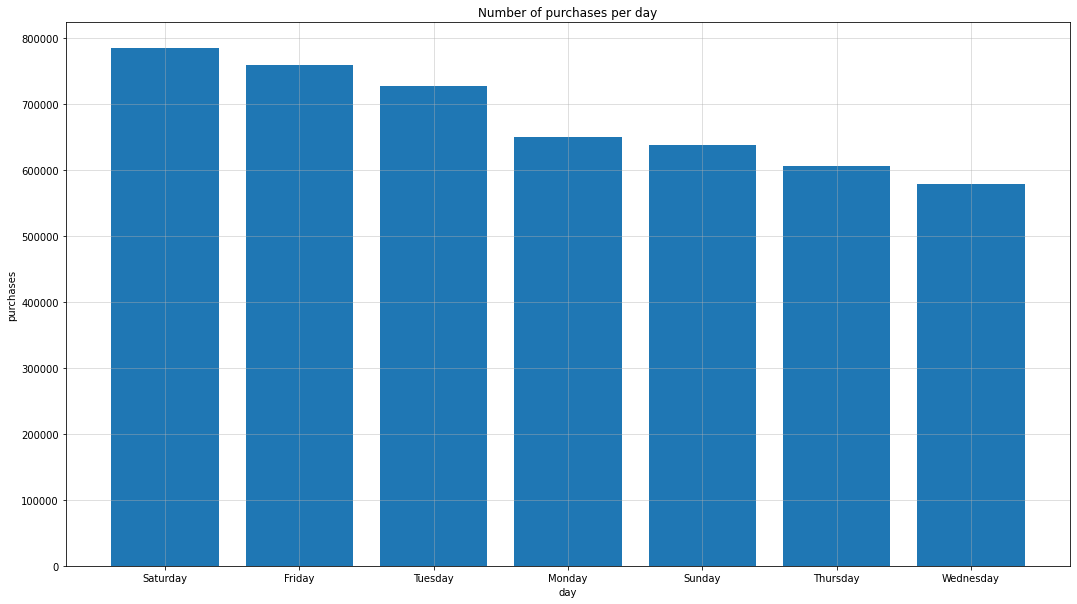

In [18]:
# print the generated curve of the session ammounts
fig, axes = plt.subplots(figsize=(18,10))

axes.bar(t_purchase_times['day'].value_counts().index,t_purchase_times['day'].value_counts())

axes.set_xlabel('day')
axes.set_ylabel('purchases')
axes.set_title('Number of purchases per day');
axes.grid(alpha=0.5)

Über ein Jahr verteilt sind die meisten Käufe gegen Ende des Jahres, ein Grund hierfür könnten die Weihnachtseinkäufe sein. 

Auffällig ist außerdem, dass im Jahr 2021 jeden Monat die Käufe des jahres 2020 übertroffen wurden. Ein Grund hierfür könnten die Lockdown Maßnahmen sein, welche wegen der Corona-Pandemie ab November 2020 beschlossen wurden.

Da die Trainingsdaten nur über einen Zeitraum von 17 Monaten aufgezeichhnet wurden gibt es für das Jahr 2021 nur für die ersten fünf Monate Daten. 



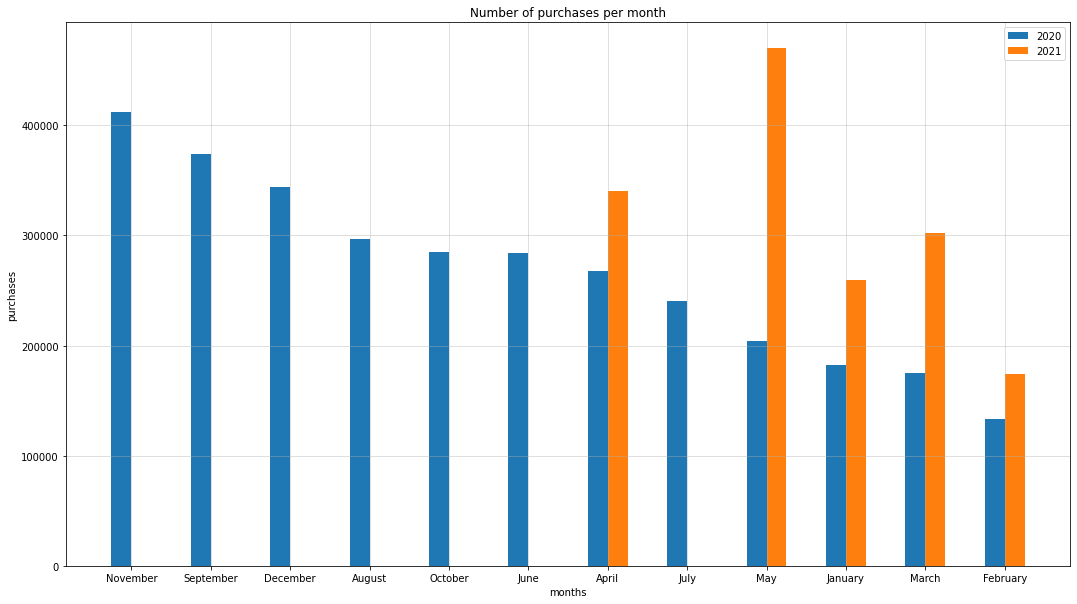

In [19]:
# print the generated curve of the session ammounts
fig, axes = plt.subplots(figsize=(18,10))

axes.bar(t_purchase_times[t_purchase_times['year']==2020]['month'].value_counts().index,t_purchase_times[t_purchase_times['year']==2020]['month'].value_counts(),align='edge', width=-0.25,label='2020')
axes.bar(t_purchase_times[t_purchase_times['year']==2021]['month'].value_counts().index,t_purchase_times[t_purchase_times['year']==2021]['month'].value_counts(),align='edge', width=0.25,label='2021')

axes.set_xlabel('months')
axes.set_ylabel('purchases')
axes.set_title('Number of purchases per month');
axes.grid(alpha=0.5)
axes.legend(loc=1);

Ein Blick auf die Verteilung der Käufe über einen Tag zeigen, dass mit abstand die wenigsten Käufe zwischen "late night" (0-4 Uhr) und "early morning" (4-8 Uhr) getätigt werden. Die restlichen Käufe wiederum teilen sich auf den verbleibenden Tage auf, wobei dabei die meisten im "evening" (16-20 Uhr) getätigt werden.

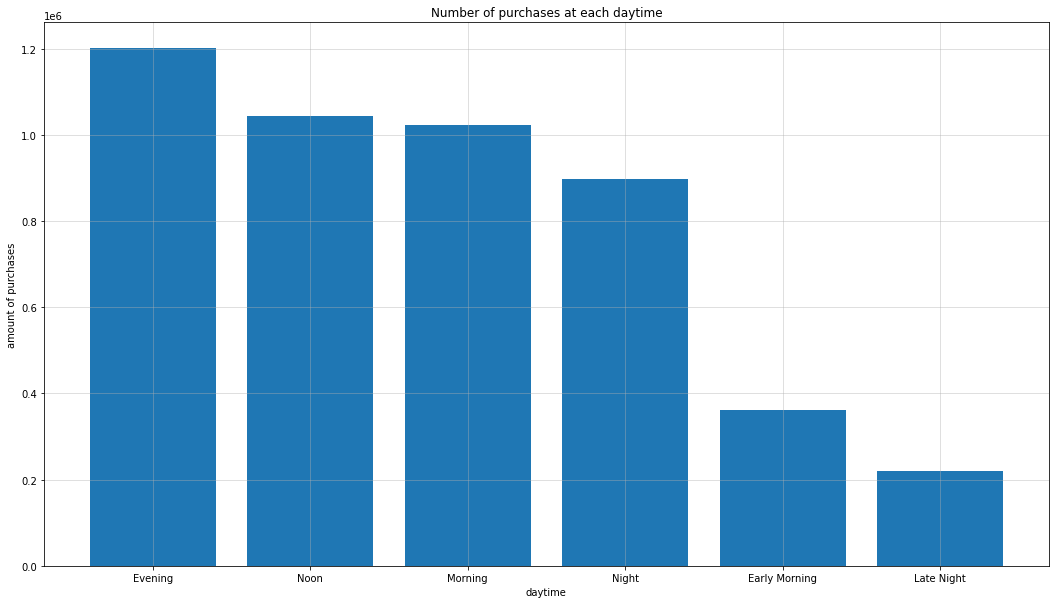

In [20]:
# print the generated curve of the session ammounts
fig, axes = plt.subplots(figsize=(18,10))

axes.bar(t_purchase_times['part_of_day'].value_counts().index,t_purchase_times['part_of_day'].value_counts())

axes.set_xlabel('daytime')
axes.set_ylabel('amount of purchases')
axes.set_title('Number of purchases at each daytime');
axes.grid(alpha=0.5)

## Welche Items wurden oft gekauft

Hier wird angesehen wie oft welches Item gekauft wurde. Also ob es bestimmte Items gibt die besonders oft gekauft werden.

Im Durchschnit wird ein item ~53 mal gekauft und das am häufigsten verkaufte item wurde 8451 mal verkauft.

In [21]:
train_purchases['item_id'].value_counts()

8060     8451
26853    3829
19882    3355
8622     2745
2447     2726
         ... 
20141       1
24646       1
1581        1
14660       1
3302        1
Name: item_id, Length: 18907, dtype: int64

In [22]:
train_purchases['item_id'].value_counts().describe()

count    18907.000000
mean        52.890464
std        126.716155
min          1.000000
25%          7.000000
50%         26.000000
75%         61.000000
max       8451.000000
Name: item_id, dtype: float64

werden die anzahl der Käufe pro item ausgegeben, sind einige Ausreißer, welche deutlich öfter gekauft wurden als z.B. der Durchschnitt.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


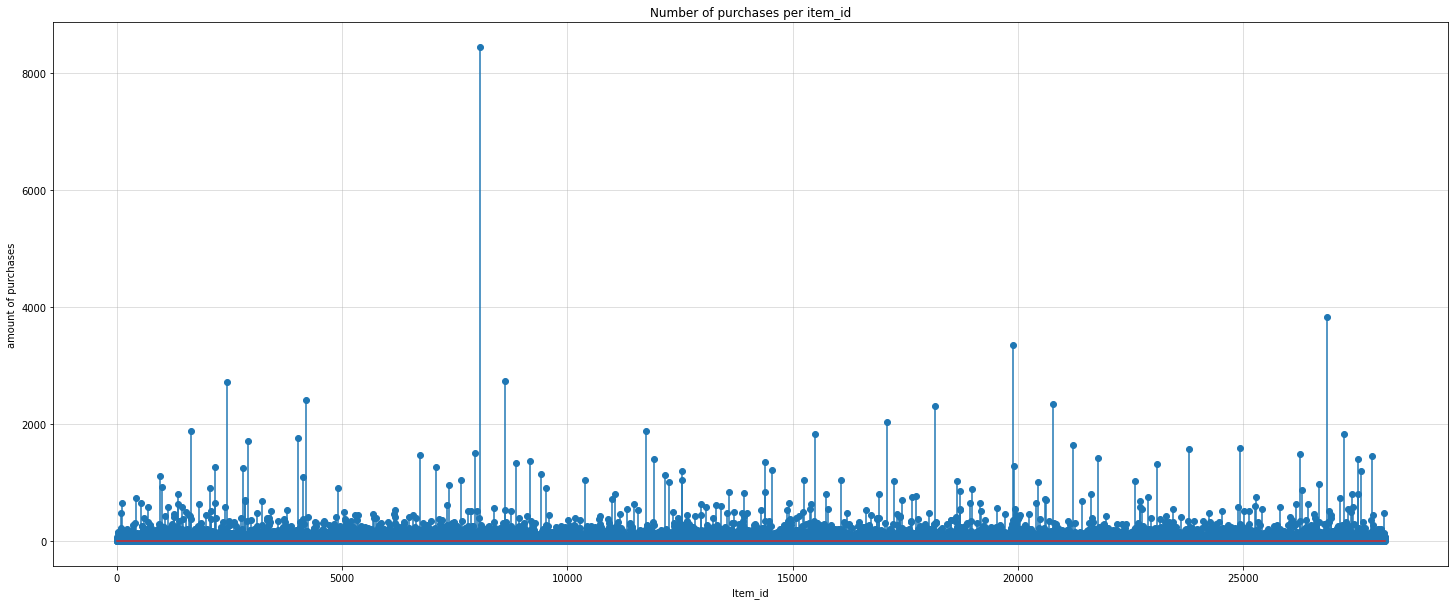

In [23]:
# print the Number of purchases per item_id
fig, axes = plt.subplots(figsize=(25,10))

axes.stem(train_purchases['item_id'].value_counts().index, train_purchases['item_id'].value_counts())

axes.set_xlabel('Item_id')
axes.set_ylabel('amount of purchases')
axes.set_title('Number of purchases per item_id');
axes.grid(alpha=0.5)

Ebenfalls deutlich wird dies bei der Ausgabe eines Boxplottes.

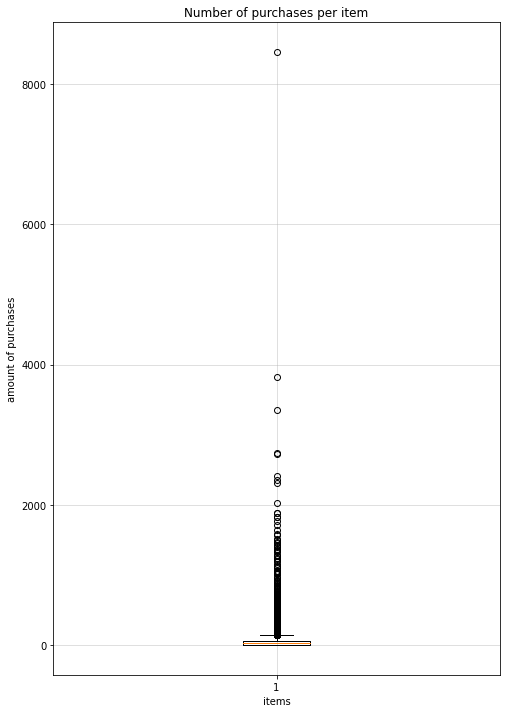

In [24]:
fig, axes = plt.subplots(figsize=(8,12))

axes.boxplot(train_purchases['item_id'].value_counts())

axes.set_xlabel('items')
axes.set_ylabel('amount of purchases')
axes.set_title('Number of purchases per item');
axes.grid(alpha=0.5)

Ein Histogramm der letzen 18500 von den 18907 items zeigt, dass die meisten items unter 100 mal gekauft wurden. 

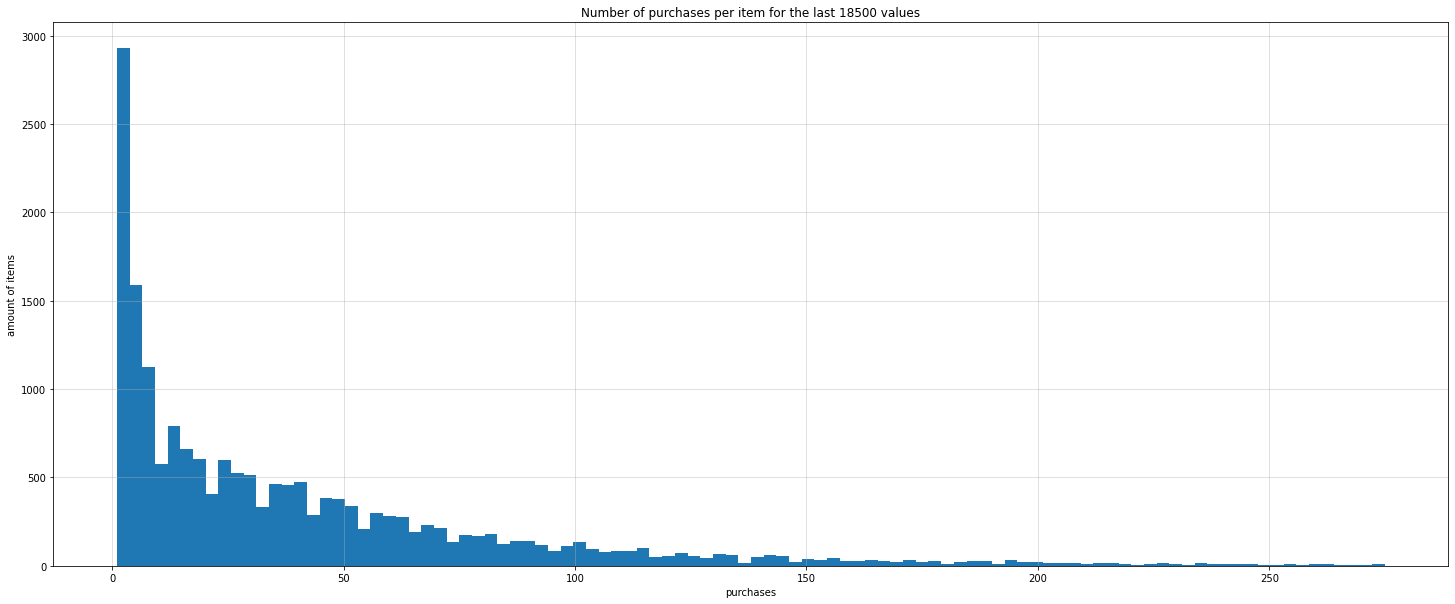

In [25]:
fig, axes = plt.subplots(figsize=(25,10))

axes.hist(train_purchases['item_id'].value_counts().tail(18500), bins=100)

axes.set_xlabel('purchases')
axes.set_ylabel('amount of items')
axes.set_title('Number of purchases per item for the last 18500 values');
axes.grid(alpha=0.5)

### Meistgekauften Items

Interesant ist auch, dass von den 18907 items

*   die 500 meistverkaufte items (2,64 % der verkauften items) sind über 25 % der Gesamtverkäufe
*   die 900 meistverkaufte items (4,76 % der verkauften items) sind über 33 % der Gesamtverkäufe
*   die 2500 meistverkaufte items (13,22 % der verkauften items) sind über 50 % der Gesamtverkäufe
*   die 5500 meistverkaufte items (29,02 % der verkauften items) sind über 75 % der Gesamtverkäufe
*   die 9454 meistverkaufte items (50,00 % der verkauften items) sind über 90 % der Gesamtverkäufe

ausmachen.



In [26]:
#purchased items
print('all in all there were',train_purchases['item_id'].value_counts().sum(), 'items sold.')

all in all there were 1000000 items sold.


the 500 most sold items ( 2.64 % of the sold items) make 262909 sales. So they make over one quater of the total sales.( 26.29 %)



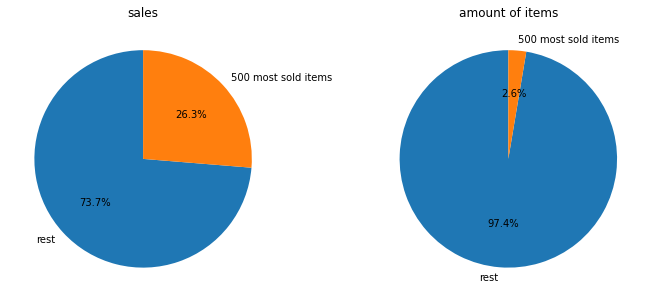

In [27]:
#purchases of the 500 most sold items
print('the 500 most sold items (',round(500/18907*100,2),'% of the sold items) make', 
      train_purchases['item_id'].value_counts().head(500).sum(), 
      'sales. So they make over one quater of the total sales.(',
      round(train_purchases['item_id'].value_counts().head(500).sum()/train_purchases['item_id'].value_counts().sum()*100,2),'%)\n')
#set values and labels for the plot
labels = 'rest', '500 most sold items'
sizes = [train_purchases['item_id'].value_counts().sum()-train_purchases['item_id'].value_counts().head(500).sum(),
         train_purchases['item_id'].value_counts().head(500).sum()]
sizes2 = [ (18907-500)/18907,500/18907]

#plot the values as pie chart
fig1, ax1 = plt.subplots(1,2,figsize=(12,5))
ax1[0].pie(sizes, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[0].set_title('sales')
ax1[1].pie(sizes2, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[1].set_title('amount of items')

plt.show()

the 900 most sold items ( 4.76 % of the sold items) make 344324 sales. So they make over one third of the total sales.( 34.43 %)



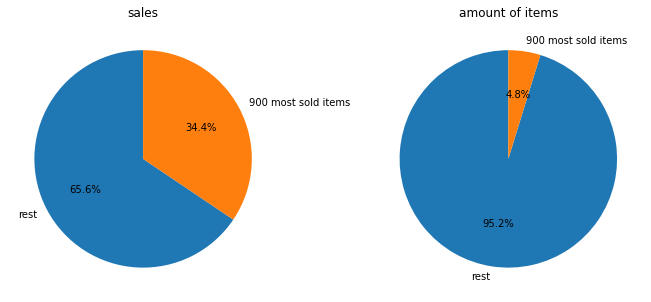

In [28]:
#purchases of the 900 most sold items
print('the 900 most sold items (',round(900/18907*100,2),'% of the sold items) make', 
      train_purchases['item_id'].value_counts().head(900).sum(), 
      'sales. So they make over one third of the total sales.(',
      round(train_purchases['item_id'].value_counts().head(900).sum()/train_purchases['item_id'].value_counts().sum()*100,2),'%)\n')
#set values and labels for the plot
labels = 'rest', '900 most sold items'
sizes = [train_purchases['item_id'].value_counts().sum()-train_purchases['item_id'].value_counts().head(900).sum(),
         train_purchases['item_id'].value_counts().head(900).sum()]
sizes2 = [ (18907-900)/18907,900/18907]

#plot the values as pie chart
fig1, ax1 = plt.subplots(1,2,figsize=(12,5))
ax1[0].pie(sizes, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[0].set_title('sales')
ax1[1].pie(sizes2, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[1].set_title('amount of items')

plt.show()

the 2500 most sold items ( 13.22 % of the sold items) make 545255 sales. So they make over the half of the total sales.( 54.53 %)



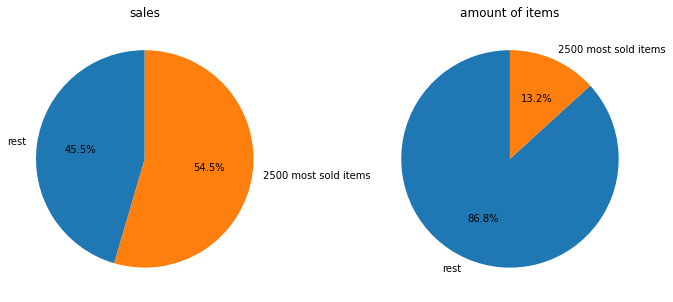

In [29]:
#purchases of the 2500 most sold items
print('the 2500 most sold items (',round(2500/18907*100,2),'% of the sold items) make', 
      train_purchases['item_id'].value_counts().head(2500).sum(), 
      'sales. So they make over the half of the total sales.(',
      round(train_purchases['item_id'].value_counts().head(2500).sum()/train_purchases['item_id'].value_counts().sum()*100,2),'%)\n')
#set values and labels for the plot
labels = 'rest', '2500 most sold items'
sizes = [train_purchases['item_id'].value_counts().sum()-train_purchases['item_id'].value_counts().head(2500).sum(),
         train_purchases['item_id'].value_counts().head(2500).sum()]
sizes2 = [ (18907-2500)/18907,2500/18907]

#plot the values as pie chart
fig1, ax1 = plt.subplots(1,2,figsize=(12,5))
ax1[0].pie(sizes, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[0].set_title('sales')
ax1[1].pie(sizes2, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[1].set_title('amount of items')

plt.show()

the 5500 most sold items ( 29.09 % of the sold items) make 758659 sales. So they make over three quaters of the total sales.( 75.87 %)



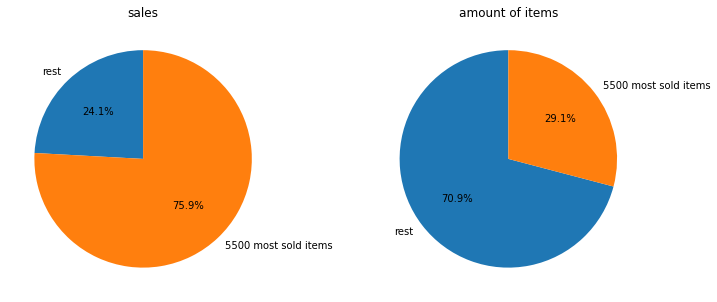

In [30]:
#purchases of the 5500 most sold items
print('the 5500 most sold items (',round(5500/18907*100,2),'% of the sold items) make', 
      train_purchases['item_id'].value_counts().head(5500).sum(), 
      'sales. So they make over three quaters of the total sales.(',
      round(train_purchases['item_id'].value_counts().head(5500).sum()/train_purchases['item_id'].value_counts().sum()*100,2),'%)\n')
#set values and labels for the plot
labels = 'rest', '5500 most sold items'
sizes = [train_purchases['item_id'].value_counts().sum()-train_purchases['item_id'].value_counts().head(5500).sum(),
         train_purchases['item_id'].value_counts().head(5500).sum()]
sizes2 = [ (18907-5500)/18907,5500/18907]
#plot the values as pie chart
fig1, ax1 = plt.subplots(1,2,figsize=(12,5))
ax1[0].pie(sizes, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[0].set_title('sales')
ax1[1].pie(sizes2, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[1].set_title('amount of items')

plt.show()

the 9454 most sold items ( 50.0 % of the sold items) make 912344 sales. So they make over 90 % of the total sales.( 91.23 %)



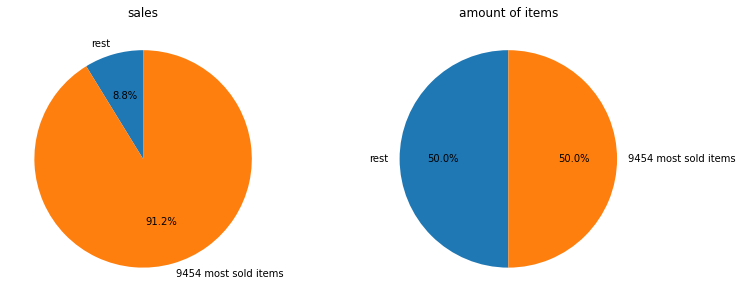

In [31]:
#purchases of the 9454 most sold items
print('the 9454 most sold items (',round(9454/18907*100,2),'% of the sold items) make', 
      train_purchases['item_id'].value_counts().head(9454).sum(), 
      'sales. So they make over 90 % of the total sales.(',
      round(train_purchases['item_id'].value_counts().head(9454).sum()/train_purchases['item_id'].value_counts().sum()*100,2),'%)\n')
#set values and labels for the plot
labels = 'rest', '9454 most sold items'
sizes = [train_purchases['item_id'].value_counts().sum()-train_purchases['item_id'].value_counts().head(9454).sum(),
         train_purchases['item_id'].value_counts().head(9454).sum()]
sizes2 = [ (18907-9454)/18907,9454/18907]
#plot the values as pie chart
fig1, ax1 = plt.subplots(1,2,figsize=(12,5))
ax1[0].pie(sizes, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[0].set_title('sales')
ax1[1].pie(sizes2, labels=labels, autopct='%1.1f%%',
         startangle=90)
ax1[1].set_title('amount of items')

plt.show()

# Data Wrangling

Um die features nutzbar zu machen, soll der Datensatz in einer Tabelle mit der item_id als index und die feature_category_ids als spalten dargestellt werde.
Allerdings gibt es in dem features Dataframe doppelte Einträge, wodurch die pivot funktion nicht direkt angewendet werden kann. 
(Damit der code an einem Stück durchlaufen kann, wurde hierfür ein Screenshot der Fehlermelung eingefügt)
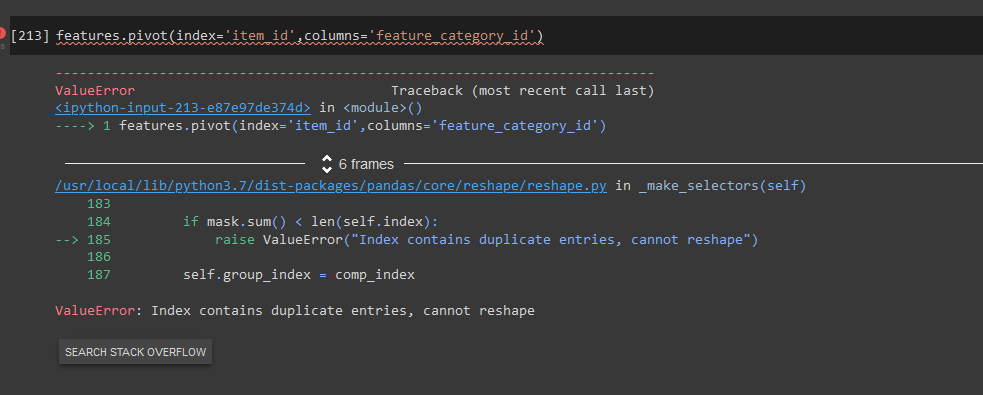

## Finden der doppelten feature_category_ids

In [32]:
#search for the duplicated feature_ids in the features DataFrame
# first drop the feature_value_id so that the duplicated feature_ids can be found
a = features.drop(['feature_value_id'],axis=1)
doub_cats = [0]*6;
j = 0;
for i in a['feature_category_id'].unique():
  if a[a['feature_category_id']== i].duplicated().sum() > 0:
    doub_cats[j] = i;
    j= j+1;
print('the duplicadet feature_category_ids are:');
doub_cats

the duplicadet feature_category_ids are:


[53, 46, 4, 30, 28, 1]

In [33]:
 #check if the duplicates are correct
 features[features['feature_category_id'] == 30]#.head()

,item_id,feature_category_id,feature_value_id
129,10,30,564
134,10,30,482
153,11,30,847
154,11,30,478
156,11,30,715
...,...,...,...
471557,28133,30,482
471561,28133,30,194
471590,28135,30,564
471593,28135,30,478


In [34]:
vals_id30 = features[features['feature_category_id'] == 30]['feature_value_id'].unique()
vals_id30.sort()
vals_id30

array([ 37,  42,  48,  62, 107, 118, 127, 136, 141, 150, 154, 173, 194,
       203, 228, 235, 259, 271, 285, 291, 325, 360, 375, 377, 391, 392,
       413, 417, 419, 426, 435, 453, 466, 478, 482, 493, 497, 532, 562,
       564, 582, 613, 638, 640, 641, 648, 654, 661, 669, 670, 715, 721,
       775, 790, 807, 809, 820, 827, 832, 835, 847, 867, 869, 880, 891,
       892, 900])

In [35]:
df = pd.DataFrame({'A': [1, 1, 1, 3, 4],

                   'B': [0, 1, 2, 0, 1]})
print(df)
df['B'] = df[df['A']==1]['B'].replace([0, 1], [9, 8])
df

   A  B
0  1  0
1  1  1
2  1  2
3  3  0
4  4  1


,A,B
0,1,9.0
1,1,8.0
2,1,2.0
3,3,NaN
4,4,NaN


In [36]:
for i in doub_cats:
  print('There are max',features[features['feature_category_id'] == i]['item_id'].value_counts().max(), 'times the feature_category_id', i, ' in one item')

There are max 2 times the feature_category_id 53  in one item
There are max 2 times the feature_category_id 46  in one item
There are max 4 times the feature_category_id 4  in one item
There are max 8 times the feature_category_id 30  in one item
There are max 3 times the feature_category_id 28  in one item
There are max 2 times the feature_category_id 1  in one item


In [37]:
for i in doub_cats:
  print('There are ',features[features['feature_category_id'] == i]['feature_value_id'].nunique(), 'different values in the feature_category_id', i, )



There are  5 different values in the feature_category_id 53
There are  4 different values in the feature_category_id 46
There are  16 different values in the feature_category_id 4
There are  67 different values in the feature_category_id 30
There are  6 different values in the feature_category_id 28
There are  6 different values in the feature_category_id 1


In [38]:
nums = features[features['feature_category_id'] == 30]['item_id'].value_counts()
nums.max()

8

In [39]:
nums.index

Int64Index([24947,  7970, 26951,  4585, 16345, 16355,  5124, 17903, 22880,
             3713,
            ...
             5527, 20501,  3108, 23737, 23735,  7496,  3111, 23727, 15054,
             3286],
           dtype='int64', length=5683)

In [40]:
bin(482<<(7*12)| 715<<(6*12) | 271<< (5*12) | 360 << (4*12) | 194 << (3*12) | 435 << (2*12) | 478 << (1*12) | 466<<(0*12))

'0b111100010001011001011000100001111000101101000000011000010000110110011000111011110000111010010'

In [41]:
bin(478) 

'0b111011110'

## Umgangs Möglichkeiten mit den doppelten Einträgen

### Doppelte Einträge löschen

Eine Möglickeit besteht darin die feature_category_ids mit dopelten Einträgen zu löschen

In [42]:
#first drop the duplicated to che if now no mare duplicates are here
c = features.drop(features[features['feature_category_id'] == 30].index)
c = c.drop(c[c['feature_category_id'] == 53].index)
c = c.drop(c[c['feature_category_id'] == 46].index)
c = c.drop(c[c['feature_category_id'] == 4].index)
c = c.drop(c[c['feature_category_id'] == 28].index)
c = c.drop(c[c['feature_category_id'] == 1].index)

Mit dem entfernen der feature_value_ids mit doppeltem vorkommen lässt sich nun die pivot function anwenden. Allerdings könnten so wichtige Eigenschaften, wie z.B. die Farben der Items nicht berücksichtigt sein.

In [43]:
#now the pivot function works, but 6 feature_category_ids are dropped
c.pivot(index='item_id',columns='feature_category_id')

feature_value_id                                       \
feature_category_id               2      3      5   6      7   8   9   10   
item_id                                                                     
2                                NaN    NaN    NaN NaN  394.0 NaN NaN NaN   
3                                NaN  889.0  605.0 NaN  452.0 NaN NaN NaN   
4                                NaN  793.0  605.0 NaN  837.0 NaN NaN NaN   
7                                NaN    NaN    NaN NaN  536.0 NaN NaN NaN   
8                                NaN  793.0  605.0 NaN  798.0 NaN NaN NaN   
...                              ...    ...    ...  ..    ...  ..  ..  ..   
28139                            NaN  793.0  605.0 NaN  798.0 NaN NaN NaN   
28140                           53.0    NaN    NaN NaN    NaN NaN NaN NaN   
28141                            NaN  889.0  605.0 NaN    2.0 NaN NaN NaN   
28142                            NaN    NaN    NaN NaN  619.0 NaN NaN NaN   
28143                            NaN    NaN    NaN NaN  798.0 NaN NaN NaN   

                                ...                                            \
feature_category_id     11  12  ...    64     65  66     67     68     69  70   
item_id                         ...                                             
2                      NaN NaN  ...   NaN    NaN NaN    NaN  351.0  885.0 NaN   
3                    859.0 NaN  ...   NaN  521.0 NaN    NaN   14.0  592.0 NaN   
4                      NaN NaN  ...   NaN  521.0 NaN    NaN  373.0  538.0 NaN   
7                      NaN NaN  ...   NaN    NaN NaN    NaN  739.0  592.0 NaN   
8                    735.0 NaN  ...   NaN  521.0 NaN    NaN  351.0  592.0 NaN   
...                    ...  ..  ...   ...    ...  ..    ...    ...    ...  ..   
28139                  NaN NaN  ...   NaN  521.0 NaN    NaN  106.0  805.0 NaN   
28140                  NaN NaN  ...  80.0    NaN NaN  349.0  351.0    NaN NaN   
28141                  NaN NaN  ...   NaN    NaN NaN    NaN  379.0  499.0 NaN   
28142                  NaN NaN  ...   NaN  610.0 NaN    NaN  895.0  740.0 NaN   
28143                109.0 NaN  ...   NaN    NaN NaN    NaN  351.0  499.0 NaN   

                                          
feature_category_id     71     72     73  
item_id                                   
2                      NaN   75.0    NaN  
3                      NaN   75.0  544.0  
4                      NaN   75.0  544.0  
7                      NaN   75.0    NaN  
8                      NaN   75.0  544.0  
...                    ...    ...    ...  
28139                  NaN   75.0  544.0  
28140                226.0    NaN  544.0  
28141                  NaN   75.0  544.0  
28142                  NaN   75.0   91.0  
28143                  NaN  371.0   91.0  

[23691 rows x 67 columns]

### pivot_table Funktion verwenden

Eine andere Möglichkeit wäre die Funktion pivot_table, hier werden allerdings die doppelten Werte z.B. auf summiert oder deren Mittelwert gebildet, was auch zu einer verfälschung der Werte führt. Damit wären keine logischen zusammenhänge mehr möglich.
Wird jeweils der minimale oder maximale Wert verwendet gehen Daten verloren, aber es würde zumindest ein unrsprünglicher Wert erhaltenbleiben.

In [64]:
feature_pivtable = features.pivot_table(index='item_id',columns='feature_category_id',  fill_value=0,aggfunc='min')
feature_pivtable

feature_value_id                                      ...  \
feature_category_id               1   2    3    4    5  6    7  8  9  10  ...   
item_id                                                                   ...   
2                                  0   0    0    0    0  0  394  0  0  0  ...   
3                                  0   0  889  618  605  0  452  0  0  0  ...   
4                                  0   0  793  618  605  0  837  0  0  0  ...   
7                                  0   0    0    0    0  0  536  0  0  0  ...   
8                                  0   0  793  618  605  0  798  0  0  0  ...   
...                              ...  ..  ...  ...  ... ..  ... .. .. ..  ...   
28139                              0   0  793  618  605  0  798  0  0  0  ...   
28140                              0  53    0    0    0  0    0  0  0  0  ...   
28141                            461   0  889  719  605  0    2  0  0  0  ...   
28142                              0   0    0    0    0  0  619  0  0  0  ...   
28143                              0   0    0    0    0  0  798  0  0  0  ...   

                                                                  
feature_category_id  64   65 66   67   68   69 70   71   72   73  
item_id                                                           
2                     0    0  0    0  351  885  0    0   75    0  
3                     0  521  0    0   14  592  0    0   75  544  
4                     0  521  0    0  373  538  0    0   75  544  
7                     0    0  0    0  739  592  0    0   75    0  
8                     0  521  0    0  351  592  0    0   75  544  
...                  ..  ... ..  ...  ...  ... ..  ...  ...  ...  
28139                 0  521  0    0  106  805  0    0   75  544  
28140                80    0  0  349  351    0  0  226    0  544  
28141                 0    0  0    0  379  499  0    0   75  544  
28142                 0  610  0    0  895  740  0    0   75   91  
28143                 0    0  0    0  351  499  0    0  371   91  

[23691 rows x 73 columns]

In [45]:
feature_pivtable[feature_pivtable.index==2].values.mean()

61.657534246575345

In [46]:
feature_pivtable.transpose().nunique().mean()

20.41817567852771

### Doppelte Einträge zusammenfassen

In [47]:
features[features['feature_category_id'] == 4].describe()

,item_id,feature_category_id,feature_value_id
count,14954.000000,14954.0,14954.000000
mean,14032.217801,4.0,608.258058
std,8133.800410,0.0,85.961140
min,3.000000,4.0,214.000000
25%,6983.250000,4.0,618.000000
50%,13978.000000,4.0,618.000000
75%,21112.750000,4.0,618.000000
max,28141.000000,4.0,865.000000


In [48]:
#q = features
#q.iloc[0,2] = hex(9|10<<4)
#q

In [49]:
a[a['feature_category_id']== 30].duplicated()

129       False
134        True
153       False
154        True
156        True
          ...  
471557     True
471561     True
471590    False
471593     True
471597     True
Length: 15412, dtype: bool

In [50]:
b = a[a['feature_category_id']== 30]
b['feature_category_id'] = 0
b.loc[a[a['feature_category_id']== 30].duplicated(), 'feature_category_id'] = 1
b

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

,item_id,feature_category_id
129,10,0
134,10,1
153,11,0
154,11,1
156,11,1
...,...,...
471557,28133,1
471561,28133,1
471590,28135,0
471593,28135,1


In [51]:
a[a['feature_category_id']== 30].duplicated()

129       False
134        True
153       False
154        True
156        True
          ...  
471557     True
471561     True
471590    False
471593     True
471597     True
Length: 15412, dtype: bool

In [52]:
features[features['feature_category_id'] == 30]['item_id']

129          10
134          10
153          11
154          11
156          11
          ...  
471557    28133
471561    28133
471590    28135
471593    28135
471597    28135
Name: item_id, Length: 15412, dtype: int64

In [53]:
features[features['feature_category_id'] == 46]['item_id'].duplicated()[features[features['feature_category_id'] == 46]['item_id'].duplicated()].index

Int64Index([5512, 99900, 273506, 456442], dtype='int64')

In [54]:
features[features.index == 99900]

,item_id,feature_category_id,feature_value_id
99900,5969,46,882


In [55]:
features[features['item_id']== 5969]

,item_id,feature_category_id,feature_value_id
99896,5969,56,153
99897,5969,47,36
99898,5969,46,71
99899,5969,50,901
99900,5969,46,882
99901,5969,61,898
99902,5969,7,452
99903,5969,72,7
99904,5969,34,275
99905,5969,32,101


In [56]:
s = features[features['item_id']== 5969]['feature_category_id']==46
s[s].index

Int64Index([99898, 99900], dtype='int64')

In [57]:
features[features.index == 99898]#['feature_value_id']

,item_id,feature_category_id,feature_value_id
99898,5969,46,71


In [58]:
Stop

NameError: ignored

### Neuer Abschnitt

In [59]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras import layers


In [115]:
# Let's say we expect our inputs to be RGB images of arbitrary size
inputs = keras.Input(shape=(73 ))

# Add a dense classifier on top
encoded1  = layers.Dense( 10, activation="relu")(inputs)
#encoded2  = layers.Dense( 35, activation="relu")(encoded1)
#encoded3  = layers.Dense( 10, activation="relu")(encoded2)


In [116]:
autoencoder = keras.Model(inputs, encoded1 )


In [117]:
comprimized = autoencoder(feature_pivtable.to_numpy())

In [118]:
comprimized = pd.DataFrame(comprimized.numpy())
comprimized

,0,1,2,3,4,5,6,7,8,9
0,68.076118,0.000000,156.141342,407.514038,0.0000,283.373932,567.841492,0.000000,0.0,220.301193
1,0.000000,0.000000,72.781967,0.000000,0.0000,345.882507,396.412109,302.101837,0.0,0.000000
2,0.000000,0.000000,216.039551,499.906860,0.0000,643.428162,197.688828,56.421490,0.0,85.670563
3,0.000000,0.000000,0.000000,302.969269,0.0000,153.017502,650.800110,0.000000,0.0,670.523315
4,0.000000,0.000000,371.111572,0.000000,0.0000,436.233124,397.051147,360.091583,0.0,188.657150
...,...,...,...,...,...,...,...,...,...,...
23686,0.000000,0.000000,0.000000,370.470245,0.0000,840.691650,330.698792,0.000000,0.0,0.000000
23687,0.000000,205.745911,0.000000,0.000000,17.7649,231.463409,0.000000,0.000000,0.0,99.945297
23688,0.000000,0.000000,0.000000,0.000000,0.0000,326.190643,0.000000,210.126968,0.0,0.000000
23689,0.000000,35.377987,18.466993,4.222428,0.0000,165.099854,673.255188,0.000000,0.0,576.135193


In [119]:
comprimized['item_id'] = feature_pivtable.index
comprimized = comprimized.set_index('item_id')

In [120]:
comprimized

,0,1,2,3,4,5,6,7,8,9
item_id,,,,,,,,,,
2,68.076118,0.000000,156.141342,407.514038,0.0000,283.373932,567.841492,0.000000,0.0,220.301193
3,0.000000,0.000000,72.781967,0.000000,0.0000,345.882507,396.412109,302.101837,0.0,0.000000
4,0.000000,0.000000,216.039551,499.906860,0.0000,643.428162,197.688828,56.421490,0.0,85.670563
7,0.000000,0.000000,0.000000,302.969269,0.0000,153.017502,650.800110,0.000000,0.0,670.523315
8,0.000000,0.000000,371.111572,0.000000,0.0000,436.233124,397.051147,360.091583,0.0,188.657150
...,...,...,...,...,...,...,...,...,...,...
28139,0.000000,0.000000,0.000000,370.470245,0.0000,840.691650,330.698792,0.000000,0.0,0.000000
28140,0.000000,205.745911,0.000000,0.000000,17.7649,231.463409,0.000000,0.000000,0.0,99.945297
28141,0.000000,0.000000,0.000000,0.000000,0.0000,326.190643,0.000000,210.126968,0.0,0.000000


In [121]:
train_sessions

,session_id,item_id,date
0,3,9655,2020-12-18 21:25:00.373
1,3,9655,2020-12-18 21:19:48.093
2,13,15654,2020-03-13 19:35:27.136
3,18,18316,2020-08-26 19:18:30.833
4,18,2507,2020-08-26 19:16:31.211
...,...,...,...
4743815,4440001,20409,2020-10-30 23:37:20.658
4743816,4440001,14155,2020-10-30 23:31:56.607
4743817,4440001,14303,2020-10-30 23:36:17.934
4743818,4440001,27852,2020-10-30 23:39:55.186


In [137]:
X = pd.merge(train_sessions, comprimized, left_on='item_id', right_on='item_id')
X = X.sort_values(by=['session_id','date'])
X

,session_id,item_id,date,0,1,2,3,4,5,6,7,8,9
1,3,9655,2020-12-18 21:19:48.093,0.0,185.967712,1.849105,0.000000,86.659485,84.474655,0.000000,0.000000,0.0,360.686493
0,3,9655,2020-12-18 21:25:00.373,0.0,185.967712,1.849105,0.000000,86.659485,84.474655,0.000000,0.000000,0.0,360.686493
117,13,15654,2020-03-13 19:35:27.136,0.0,0.000000,117.877022,241.889023,0.000000,350.867950,434.576416,0.000000,0.0,801.528809
790,18,4026,2020-08-26 19:15:47.232,0.0,0.000000,112.933975,128.545929,0.000000,382.237823,0.000000,133.625122,0.0,0.000000
254,18,2507,2020-08-26 19:16:31.211,0.0,0.000000,152.210678,251.758743,0.000000,755.144958,239.941635,224.369476,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2656413,4440001,14303,2020-10-30 23:36:17.934,0.0,0.000000,162.142334,341.530518,0.000000,805.109619,188.715088,321.061188,0.0,0.000000
3778618,4440001,19539,2020-10-30 23:37:09.46,0.0,0.000000,219.443283,535.231689,0.000000,579.807861,524.371155,0.000000,0.0,46.323143
1656723,4440001,20409,2020-10-30 23:37:20.658,0.0,0.000000,331.686920,496.280640,0.000000,662.987488,517.306274,0.000000,0.0,0.000000
853151,4440001,27852,2020-10-30 23:39:55.186,0.0,0.000000,192.018387,123.135262,0.000000,195.896225,394.200897,0.000000,0.0,213.502762


In [133]:
X[9].value_counts()

0.000000      1273878
46.323143       14860
33.291245       14714
701.559143      13192
115.421371      10951
               ...   
303.002747          1
555.236389          1
308.625397          1
276.977875          1
141.417358          1
Name: 9, Length: 17794, dtype: int64

In [108]:
#randomly split into train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

NameError: ignored

# Baseline 

## Erstellen eines zufälligen Test scores
Erstellen eines Zufälligen Testscores mit je 100 zufälligen Item ids pro Session. Die item ids werden hierfür aus der items liste entnommen.

In [ ]:
rand_pred = pd.DataFrame();
rand_pred['session_id'] = test_leaderboard_sessions['session_id'].unique()
rand_pred  = rand_pred.loc[rand_pred.index.repeat(100)].reset_index(drop=True)
rand_pred['item_id'] = pd.DataFrame(np.random.randint(items['item_id'].min(), items['item_id'].max(), size=(len(rand_pred),1)))
rand_pred['rank'] = rand_pred.groupby('session_id').cumcount()+1
rand_pred = rand_pred.set_index('session_id')


In [ ]:
rand_pred = pd.DataFrame();
rand_pred['session_id'] = test_leaderboard_sessions['session_id'].unique()
rand_pred  = rand_pred.loc[rand_pred.index.repeat(100)].reset_index(drop=True)
rand_pred['item_id'] = np.random.choice(items['item_id'], size=(len(rand_pred)))
rand_pred['rank'] = rand_pred.groupby('session_id').cumcount()+1
rand_pred = rand_pred.set_index('session_id')

In [ ]:
rand_pred.head(102)

In [ ]:
rand_pred.to_csv('rand_pred.csv')

## Vorschlagen des letzten angesehen item

Da in den meisten sessions nur ein item angesehen wird, werden als nächstes die ids vorgeschlagen, wechle zuletzt in der Session angesehen wurden.

In [ ]:
test2 = pd.DataFrame();

In [ ]:
#test2['session_id'] = test_leaderboard_sessions['session_id'].unique();
idx = test_leaderboard_sessions.groupby(['session_id'])['date'].transform(max) == test_leaderboard_sessions['date']

In [ ]:
test2 = test_leaderboard_sessions[idx]

In [ ]:
test2 = test2.reset_index()

In [ ]:
test2['session_id']

In [ ]:
test2

In [ ]:
test_leaderboard_sessions.head(20)

In [ ]:
a = test2['session_id'].duplicated() == test2['session_id']

In [ ]:
a

In [ ]:
test3  = pd.DataFrame()

In [ ]:
test3['session_id'] = test_leaderboard_sessions['session_id'].unique()
test3['item_id'] = test2['item_id']
test3['rank'] = 1
test3 = test3.set_index('session_id')

In [ ]:
test3

In [ ]:
test3.to_csv('test3.csv')

## Vorschlagen zufälliger items aus den X meistgekauften items
Wie in Abschnitt Datenalyse/Welche items wurden oft gekauft/ gezeigt sind die meisten verkäufe auf vergleichsweise wenige items zurückzuführen. Aus diesem Grund werden hier für drei Beispiele zufällige Vorhersagen erstellt. Mit den


*   900 meist verkauften items
*   2500 meist verkauften items
*   9454 meist verkauften items
*   500 meist verkauften items





---

900 meist verkaufte items (Score = 0,002149192564937604)

In [ ]:
#write the item its of the 900 most bought items in the variable MBI900
MBI900 = train_purchases['item_id'].value_counts().head(900).index
MBI900

In [ ]:
# generate a random prediction with the 500 most bougth items 
mbi900_pred = pd.DataFrame();
mbi900_pred['session_id'] = test_leaderboard_sessions['session_id'].unique()
mbi900_pred  = mbi900_pred.loc[mbi900_pred.index.repeat(100)].reset_index(drop=True)
mbi900_pred['item_id'] = np.random.choice(MBI900, size=(len(mbi900_pred)))
mbi900_pred['rank'] = mbi900_pred.groupby('session_id').cumcount()+1
mbi900_pred = mbi900_pred.set_index('session_id')

In [ ]:
mbi900_pred

In [ ]:
mbi900_pred.to_csv('mbi900_pred.csv')



---

2500 meist verkaufte items (Score =  8.35697856586405e-05 )

In [ ]:
#write the item its of the 2500 most bought items in the variable MBI2500
MBI2500 = train_purchases['item_id'].value_counts().head(2500).index
# generate a random prediction with the 500 most bougth items 
mbi2500_pred = pd.DataFrame();
mbi2500_pred['session_id'] = test_leaderboard_sessions['session_id'].unique()
mbi2500_pred  = mbi2500_pred.loc[mbi2500_pred.index.repeat(100)].reset_index(drop=True)
mbi2500_pred['item_id'] = np.random.choice(MBI2500, size=(len(mbi2500_pred)))
mbi2500_pred['rank'] = mbi2500_pred.groupby('session_id').cumcount()+1
mbi2500_pred = mbi2500_pred.set_index('session_id')

mbi2500_pred.to_csv('mbi2500_pred.csv')



---

9454 meist verkaufte items (Score =  0.0004470316405966391)

In [ ]:
#write the item its of the 9454 most bought items in the variable MBI9454
MBI9454 = train_purchases['item_id'].value_counts().head(9454).index
# generate a random prediction with the 500 most bougth items 
mbi9454_pred = pd.DataFrame();
mbi9454_pred['session_id'] = test_leaderboard_sessions['session_id'].unique()
mbi9454_pred  = mbi9454_pred.loc[mbi9454_pred.index.repeat(100)].reset_index(drop=True)
mbi9454_pred['item_id'] = np.random.choice(MBI9454, size=(len(mbi9454_pred)))
mbi9454_pred['rank'] = mbi9454_pred.groupby('session_id').cumcount()+1
mbi9454_pred = mbi9454_pred.set_index('session_id')

mbi9454_pred.to_csv('mbi9454_pred.csv')



---

500 meist verkaufte items (Score =   0.0030179652295973616)

In [ ]:
#write the item its of the 9454 most bought items in the variable MBI9454
MBI500 = train_purchases['item_id'].value_counts().head(500).index
# generate a random prediction with the 500 most bougth items 
mbi500_pred = pd.DataFrame();
mbi500_pred['session_id'] = test_leaderboard_sessions['session_id'].unique()
mbi500_pred  = mbi500_pred.loc[mbi500_pred.index.repeat(100)].reset_index(drop=True)
mbi500_pred['item_id'] = np.random.choice(MBI500, size=(len(mbi500_pred)))
mbi500_pred['rank'] = mbi500_pred.groupby('session_id').cumcount()+1
mbi500_pred = mbi500_pred.set_index('session_id')

mbi500_pred.to_csv('mbi500_pred.csv')

# Euklidische Distanz

In [ ]:
stop

In [ ]:
q = np.array(feature_pivtable[feature_pivtable.index==2])+np.array(feature_pivtable[feature_pivtable.index==30])
w = np.array(feature_pivtable[feature_pivtable.index==11])+np.array(feature_pivtable[feature_pivtable.index==46])

q = q/np.linalg.norm(q)
w = w/np.linalg.norm(w)

np.linalg.norm(q-w)

In [ ]:
q

In [ ]:

pd.concat([pd.DataFrame(q),pd.DataFrame(w)])

In [ ]:
#euclidean distance
temp  = [0 for a in range(len(np.array(feature_pivtable)))]
q = np.array(feature_pivtable[feature_pivtable.index==2])
q = q/np.linalg.norm(q)
ii = 0;
for i in np.array(feature_pivtable.index):
  w = np.array(feature_pivtable[feature_pivtable.index==i])
  w = w/np.linalg.norm(w)
  temp[ii] = np.linalg.norm(q-w)
  ii = ii+1;

In [ ]:
temp = pd.DataFrame(temp)
temp['item_id'] = features['item_id'].unique()
temp = temp.set_index('item_id')

In [ ]:
temp.sort_values(by=0).head(100)

In [ ]:
#cosine distance
from scipy.spatial import distance


temp  = [0 for a in range(len(np.array(feature_pivtable)))]
q = np.array(feature_pivtable[feature_pivtable.index==2])
q = q/np.linalg.norm(q)
ii = 0
for i in np.array(feature_pivtable.index):
  w = np.array(feature_pivtable[feature_pivtable.index==i])
  w = w/np.linalg.norm(w)
  temp[ii] = 1 - distance.cosine(q,w)
  ii = ii+1

In [ ]:
temp = pd.DataFrame(temp)
temp['item_id'] = features['item_id'].unique()
temp = temp.set_index('item_id')

In [ ]:
temp.sort_values(by=0).tail(100)

## Präparieren der Daten

In [ ]:
eucl = test_leaderboard_sessions.drop('date', axis= 1)
eucl

In [ ]:
test = eucl.set_index('item_id').join(feature_pivtable['feature_value_id'],how='inner')

In [ ]:
# summarize all vectors from one session 
test = test.groupby('session_id').sum()
test

## Berechnen der Euklidischen Distanz

In [ ]:
w = np.zeros((len(np.array(feature_pivtable)),73))
ii = 0
for i in feature_pivtable.index:
  w[ii] = feature_pivtable[feature_pivtable.index==i]['feature_value_id']
  w[ii] = w[ii]/np.linalg.norm(w[ii])
  ii = ii+1
w = pd.DataFrame(w)
w = w.transpose()
w

In [ ]:
def Euclidean_Dist(df1, df2, cols=list(w.columns)):
    return np.linalg.norm(df1[cols].values - df2[cols].values,
                   axis=0)

In [ ]:
#euclidean distance
def euclidean_dist(x):
  q = np.array(test[test.index==x])
  q = q/np.linalg.norm(q)
  q = np.array([q[0],]*len(np.array(feature_pivtable)))
  q = pd.DataFrame(q)
  q = q.transpose()

  temp = Euclidean_Dist(q, w)

  temp = pd.DataFrame(temp)
  temp['item_id'] = features['item_id'].unique()
  temp = temp.set_index('item_id')

  return temp.sort_values(by=0).head(100).index

In [ ]:
def eucl_reduce(a,b):
  return pd.concat([pd.DataFrame(a),pd.DataFrame(b)], ignore_index=True)#a.append(b) #

In [ ]:
%%time
l = list(map(euclidean_dist,lst))

In [ ]:
l

In [ ]:
temp = Euclidean_Dist(q, w)

temp = pd.DataFrame(temp)
temp['item_id'] = features['item_id'].unique()
temp = temp.set_index('item_id')

temp.sort_values(by=0)


In [ ]:
%%time

import functools 

k = (functools.reduce(eucl_reduce,l)) 

In [ ]:
k

In [ ]:
# generate the Dataframe for the leaderboard score
eucl_dist = pd.DataFrame();
eucl_dist['session_id'] = test_leaderboard_sessions['session_id'].unique()
eucl_dist  = eucl_dist.loc[eucl_dist.index.repeat(100)].reset_index(drop=True)
eucl_dist['item_id'] = k
eucl_dist['rank'] = eucl_dist.groupby('session_id').cumcount()+1
eucl_dist = eucl_dist.set_index('session_id')
eucl_dist

In [ ]:
eneucl_dist.to_csv('eucl_dist.csv')

Finden der ids, welche nicht in eucl_dist vorhanden sind

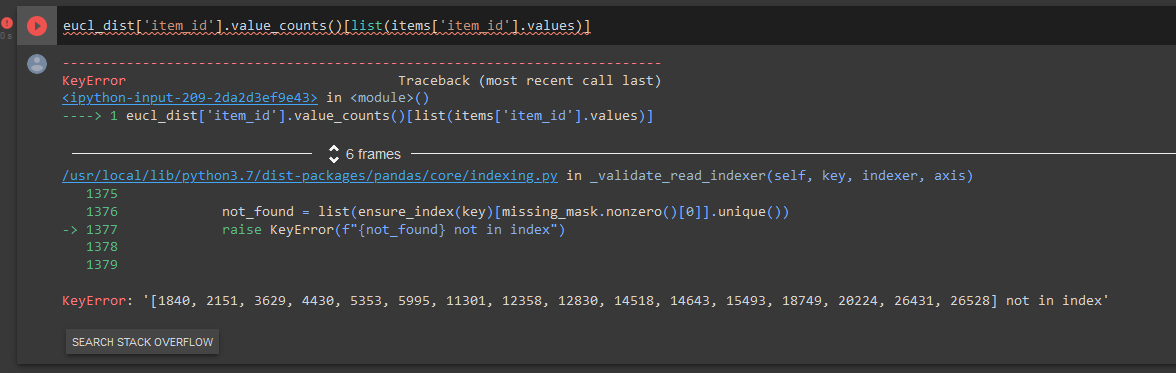

Wird geprüft wie viele der erhaltenen Items aus eucl_dist sich in dem items Datensatz befinden, erhält man 57,77986 %. Damit sind in dieser Vorherssage über die Hälfte der Vorgeschalgenen Items tatsächlich gekauft worden.

Der score betrug für eucl_dist 0.02395626959030891 -> ~ 2.4 %. 

In [ ]:
s = list(items['item_id'].values)
#the values in o are not in eucl_dist, so they get removed
o =[1840, 2151, 3629, 4430, 5353, 5995, 11301, 12358, 12830, 14518, 14643, 15493, 18749, 20224, 26431, 26528]
for i in o:
  s.remove(i)
#print the percentage of the item ids witch contained in items  
eucl_dist['item_id'].value_counts()[s].sum() / eucl_dist['item_id'].value_counts().sum()*100



---

### Nicht Normiert

Zum Vergleich wird hier nocheinmal eine Vorhersage mit der Euklidischen Distanz getätigt, allerdings werden die Vektoren diesmal nicht Normiert.

In [ ]:
w2 = np.zeros((len(np.array(feature_pivtable)),73))
ii = 0
for i in feature_pivtable.index:
  w2[ii] = feature_pivtable[feature_pivtable.index==i]['feature_value_id']
  #w[ii] = w[ii]/np.linalg.norm(w[ii])
  ii = ii+1
w2 = pd.DataFrame(w2)
w2 = w2.transpose()
w2

In [ ]:
#euclidean distance nicht normiert
def euclidean_dist2(x):
  q = np.array(test[test.index==x])
  #q = q/np.linalg.norm(q)
  q = np.array([q[0],]*len(np.array(feature_pivtable)))
  q = pd.DataFrame(q)
  q = q.transpose()

  temp = Euclidean_Dist(q, w2)

  temp = pd.DataFrame(temp)
  temp['item_id'] = features['item_id'].unique()
  temp = temp.set_index('item_id')

  return temp.sort_values(by=0).head(100).index


In [ ]:
%%time
l2 = (map(euclidean_dist2,list(test.index)))

In [ ]:
%%time

import functools 

k2 = (functools.reduce(eucl_reduce,l2)) 

In [ ]:
k2

In [ ]:
# generate the Dataframe for the leaderboard score
eucl_dist2 = pd.DataFrame();
eucl_dist2['session_id'] = test_leaderboard_sessions['session_id'].unique()
eucl_dist2  = eucl_dist2.loc[eucl_dist2.index.repeat(100)].reset_index(drop=True)
eucl_dist2['item_id'] = k2
eucl_dist2['rank'] = eucl_dist2.groupby('session_id').cumcount()+1
eucl_dist2 = eucl_dist2.set_index('session_id')
eucl_dist2

In [ ]:
eucl_dist2.to_csv('eucl_dist2.csv')

Finden der ids, welche nicht in eucl_dist2 vorhanden sind.

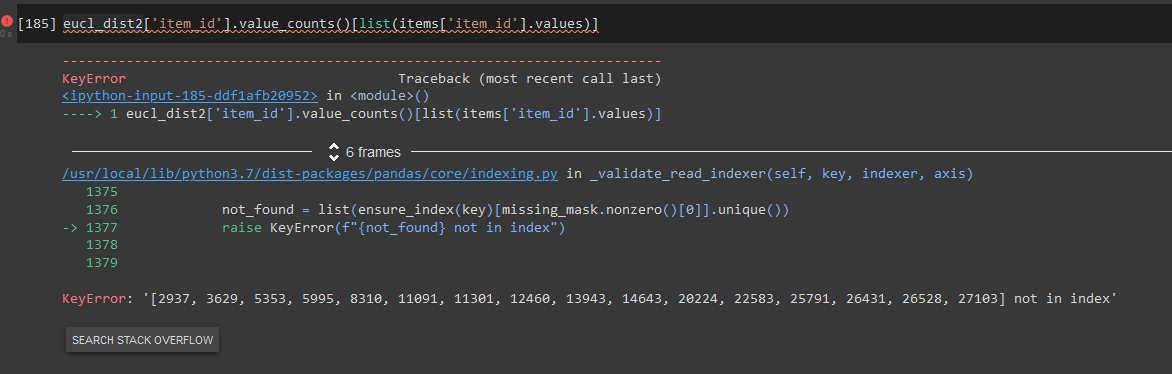

Wird geprüft wie viele der erhaltenen Items aus eucl_dist2 sich in dem items Datensatz befinden, erhält man 42,60928 %. Damit sind in dieser Vorherssage weniger als die Hälfte der Vorgeschalgenen Items tatsächlich gekauft worden.

Der score betrug für eucl_dist2 0,015383501137446897  -> ~  	1,54  %. 

In [ ]:
s = list(items['item_id'].values)
#the values in o are not in eucl_dist, so they get removed
o =[2937, 3629, 5353, 5995, 8310, 11091, 11301, 12460, 13943, 14643, 20224, 22583, 25791, 26431, 26528, 27103]
for i in o:
  s.remove(i)
#print the percentage of the item ids witch contained in items 
eucl_dist2['item_id'].value_counts()[s].sum() / eucl_dist2['item_id'].value_counts().sum()*100

In [ ]:
lst = [26 ,200]

In [ ]:
w3 = np.zeros((len(np.array(feature_pivtable)),73))
ii = 0
for i in feature_pivtable.index:
  w3[ii] = feature_pivtable[feature_pivtable.index==i]['feature_value_id']
  w3[ii] = w3[ii]/np.linalg.norm(w3[ii])
  ii = ii+1
w3 = pd.DataFrame(w3)
#w3 = w3.transpose()
w3

In [ ]:
def Euclidean_Dist3(df1, df2):
    #return Lst.apply(lambda columns: cosine(df2[columns], df1[columns]), axis=1)
    return paired_cosine_distances(df1,df2)

In [ ]:
#euclidean distance
def euclidean_dist3(x):
  q = np.array(test[test.index==x])
  q = q/np.linalg.norm(q)
  q = np.array([q[0],]*len(np.array(feature_pivtable)))
  q = pd.DataFrame(q)
  #q = q.transpose()

  temp = Euclidean_Dist3(q, w3)

  temp = pd.DataFrame(temp)
  temp['item_id'] = features['item_id'].unique()
  temp = temp.set_index('item_id')

  return temp.sort_values(by=0).head(100).index

In [ ]:
def eucl_reduce3(a,b):
  return pd.concat([pd.DataFrame(a),pd.DataFrame(b)], ignore_index=True)

In [ ]:
%%time
l3 = (map(euclidean_dist3,list(test.index)))

In [ ]:
q = np.array(test[test.index==26])
q = q/np.linalg.norm(q)
#q = np.array([q[0],]*len(np.array(feature_pivtable)))
q = pd.DataFrame(q)
q = q.transpose()

  #temp = Euclidean_Dist3(q, w3)


q
  

In [ ]:
cosine(q[0],w3[w3.index==18])

In [ ]:
q[0]

In [ ]:
w3[w3.index==18]

In [ ]:
temp[temp.index==26]

In [ ]:
%%time

import functools 

k3 = (functools.reduce(eucl_reduce3,l3)) 

In [ ]:
k3

In [ ]:
# generate the Dataframe for the leaderboard score
eucl_dist3 = pd.DataFrame();
eucl_dist3['session_id'] = test_leaderboard_sessions['session_id'].unique()
eucl_dist3  = eucl_dist3.loc[eucl_dist3.index.repeat(100)].reset_index(drop=True)
eucl_dist3['item_id'] = k3
eucl_dist3['rank'] = eucl_dist3.groupby('session_id').cumcount()+1
eucl_dist3 = eucl_dist3.set_index('session_id')
eucl_dist3


In [ ]:
eucl_dist3.to_csv('eucl_dist3.csv')

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity,paired_cosine_distances
from scipy.spatial.distance import cosine

In [ ]:
A = pd.DataFrame()
A[0] = [2,2,3]
A[1] = [2,3,2]

B = pd.DataFrame()
B[0] = [8,2,3]
B[1] = [2,3,2]

list(A.columns)
paired_cosine_distances(A,B)


In [ ]:
cosine(A[A.index==1],B[B.index==1])

In [ ]:
A

In [ ]:
B

In [ ]:
k3[k3['item_id']==19185]

In [ ]:
  q = np.array(test[test.index==26])
  q = q/np.linalg.norm(q)
  q = np.array([q[0],]*len(np.array(feature_pivtable)))
  q = pd.DataFrame(q)
  q = q.transpose()
  q

In [ ]:
lst = pd.DataFrame(lst)

In [ ]:
%%time
from scipy.spatial.distance import cosine

df =Lst.apply(lambda row: 1 - cosine(w3[row], q[row]), axis=1)

In [ ]:
df

In [ ]:
A = np.array(q[200])

In [ ]:
B = np.array(w3[200])

In [ ]:
1 - cosine(A, B)

In [ ]:
Lst = pd.DataFrame(list(range(23691 )))

# Tensorflow recomenders